# *svoboda lab / tactile navigation*

This notebook loads and plots the summary imaging data found in SofroniewVlasov2015

## Setup evnironment

In [1]:
import os
import numpy as np
import pandas as pd
import json

## Setup plotting

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')
from helper.plots import *
savefig = False

## Helper functions for loading and processing data

This helper function is using during loading to align tables to a primary key

In [3]:
def align(table, primary, index):
    table['sourceId'] = primary['sourceId']
    table.set_index(index,inplace = True)
    table.columns = table.columns.astype('float')
    return table

This helper function loads mutliple tables from a session into a dictionary where the keys are table names

In [4]:
def load(session):
    # load the info
    with open(os.path.join(path,'data',session,'info.json')) as infile:
        info = json.load(infile)
        
    d = {}

    # load the units (which have our primary keys)
    d['units'] = pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','units.csv'))
    d['units']['sourceId'] = d['units'].index
    
    # load all the tables    
    d['tuning'] = pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','tuning.csv'))   
    d['tuning'] = align(d['tuning'], d['units'], ['sourceId', 'label'])
    d['tuningNum'] = d['tuning'].xs('numTrials', level='label')
    err = d['tuning'].xs('stdRate', level='label').divide(d['tuningNum'].apply(np.sqrt))
    d['tuning'] = d['tuning'].xs('meanRate', level='label')
    d['tuningErr'] = err
    d['tuningSummary'] = summarizeTuning(d['tuning'])
  
    d['units'] = d['units'].drop(['sourceId'], axis=1)
    
    # add tables
    d = pd.concat([d[x] for x in d.keys()], axis = 1, keys = d.keys())
    
    info['contributors'] = ', '.join(info['contributors'])
    info['dimensions'] = str(info['dimensions'])
    info['session'] = session
    info = pd.DataFrame(info, index = [str(info['id'])])
    
    #d['info'] = info
    return d, info

#### Append position tuning information to units data frame

In [5]:
def summarizeTuning(df):
    x = df.columns.values
    xs, ys = smoothfit(x, df.values[0],smooth=smooth)
    smoothed = [smoothfit(x, y, smooth=smooth)[1] for y in df.values]

    summary = pd.DataFrame(index=df.index)
    summary['Baseline'] = [y[-1] for y in smoothed]
    summary['Max'] = [max(y) for y in smoothed]
    summary['ArgMax'] = [xs[np.argmax(y)] for y in smoothed]
    summary['Min'] = [min(y) for y in smoothed]
    summary['Mean'] = [np.mean(y) for y in smoothed]

    summary['Activation'] = summary.Max - summary.Baseline
    summary['Supression'] = summary.Baseline - summary.Min
    summary['Range'] = summary.Max - summary.Min
    summary['Modulation'] = (summary.Activation - summary.Supression)/(summary.Activation + summary.Supression)
    summary['TotalModulation'] = (summary.Max - summary.Min)/(summary.Max + summary.Min)
    return summary

#### Define smooth parameter

In [6]:
smooth = 1

## Load JSON + CSV as DataFrames

#### Specify location of the data

In [7]:
path = os.path.expanduser('~/Dropbox/paper.tuning')

#### Load the tables from each session

In [8]:
sessions = range(13,19)
data = [load('%02g' % s) for s in sessions]
table =  pd.concat([x[0] for x in data], keys=[str(x[1].index[0]) for x in data], names=['anmId'])
info =  pd.concat([x[1] for x in data])

/Users/sofroniewn/anaconda/lib/python2.7/site-packages/scipy/interpolate/fitpack2.py:188: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


## Summarize units

#### Summarize units

In [9]:
units = table.units.reset_index()
unitCount = units.groupby(['anmId']).count()['sourceId'].values
units.set_index(['anmId', 'sourceId'], inplace=True)
print np.mean(unitCount), np.std(unitCount), len(unitCount)

336.5 69.8754844944 6


#### Plot fractions of active and tuned neurons

In [10]:
tuned = (units.pVal<0.05) & (table.tuningSummary.Range > .3)
active = units.activity > 1.0
summaryActivity = pd.DataFrame([sum((~active) & (~tuned)), sum(tuned), sum(active & (~tuned))], index=['inactive','tuned','untuned'], columns=['number'])
summaryActivity['percent'] = 100*summaryActivity.number/summaryActivity.number.sum()
summaryActivity

,number,percent
inactive,1121,55.522536
tuned,564,27.934621
untuned,334,16.542843


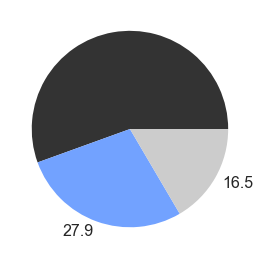

In [11]:
col = colormap()(0)[:3]
plt.axes(aspect=1);
plt.pie(summaryActivity.percent, labels=['','%.1f' % summaryActivity.percent.iloc[1],'%.1f' % summaryActivity.percent.iloc[2]], colors=[[.2, .2, .2],col,[.8, .8, .8]], wedgeprops={'linewidth':0});
if savefig:
    plt.savefig(os.path.join(path,'figuresImaging','Percentages.eps'))

## Keep significantly tuned units

In [12]:
table = table[tuned.values]

## Plot summary tuning curves

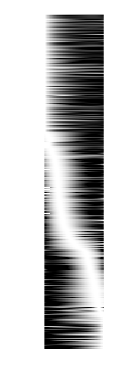

In [13]:
curves = table.sort([('tuningSummary','ArgMax')])
xy = [(curves.tuning.columns.values, y) for y in curves.tuning.values]
fits = smootharray(xy, smooth=smooth, res=100)
heatmap(fits, aspect=1)
if savefig:
    plt.savefig(os.path.join(path,'figuresImaging','Tuning%s_units.eps' % len(fits)))

## Plot summary tuning

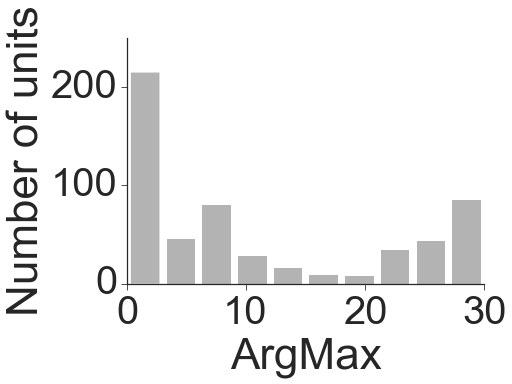

In [20]:
hist(table.tuningSummary.ArgMax, xlabel='ArgMax', ylabel='Number of units')
plt.xticks(range(0,40,10))
plt.yticks(range(0,300,100))
if savefig:
    plt.savefig(os.path.join(path,'figuresImaging','DistancePeaks.eps'))

# Plot tuning curves

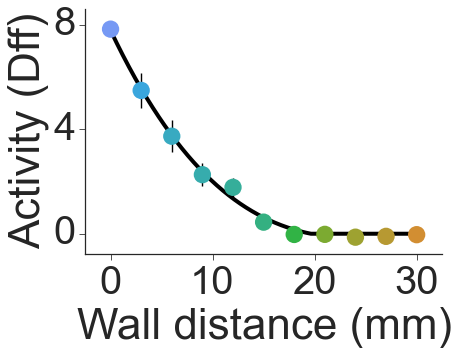

In [25]:
a = 'Anm_0216166'
u = 150
x = table.tuning.columns.values
y = table.tuning.loc[a,u].values
err = table.tuningErr.loc[a,u].values
tuning(x, y, err, smooth=smooth, ylabel='Activity (Dff)');

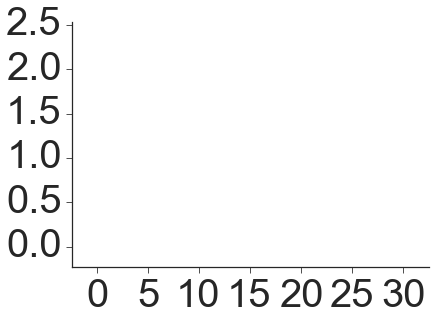

In [19]:
animals = ['Anm_0216166', 'Anm_0216166', 'Anm_0216166']
sourcesPlot = [150, 160, 159]

for a, u in zip(animals, sourcesPlot):
    x = table.tuning.columns.values
    y = table.tuning.loc[a,u].values
    err = table.tuningErr.loc[a,u].values
    rng = tuning(x, y, err, smooth=smooth, ylabel='Activity (Dff)');
    if savefig:
        plt.savefig(os.path.join(path,'figuresImaging','Tuning%s_%s.eps' % (a, u)))
    plt.cla()

#Plot maps and traces

#### Import thunder

In [43]:
from thunder import ThunderContext
tsc = ThunderContext(None)
from thunder.extraction import Source, SourceModel
from thunder.extraction import BasicCleaner
from thunder import Colorize
image = Colorize.image
tile = Colorize.tile

#### Load maps

In [44]:
a = 'Anm_0216166'
session = info.session.loc[a]

In [45]:
mean = np.load(os.path.join(path,'data',session,'maps','mean.npy'))
localCorr = np.load(os.path.join(path,'data',session,'maps','localCorr.npy'))
rsq = np.load(os.path.join(path,'data',session,'maps','rsq.npy'))
tune = np.load(os.path.join(path,'data',session,'maps','tuning.npy'))

#### Plot maps

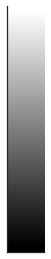

In [46]:
palBW = plt.get_cmap('gray')
colorbar(palBW)
if savefig:
    plt.savefig(os.path.join(path,'figuresImaging','ColorbarGray.eps'))

In [47]:
pal = colormap(0)
if savefig:
    plt.savefig(os.path.join(path,'figuresImaging','Colorbar.eps'))

In [48]:
iplane = 2

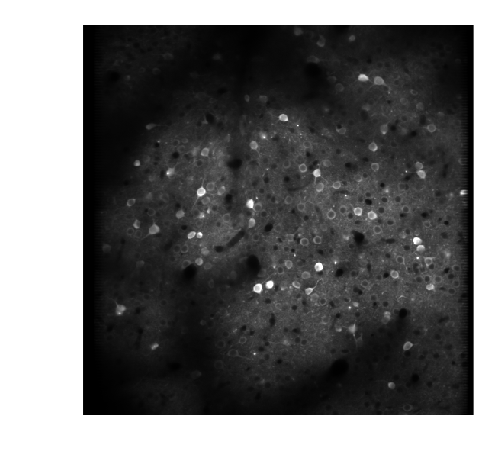

In [49]:
image(mean[:,:,iplane], clim=(0,500))

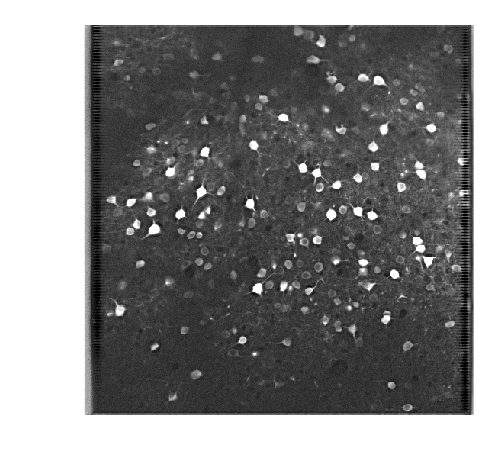

In [50]:
image(localCorr[:,:,iplane], clim=(0,.5))

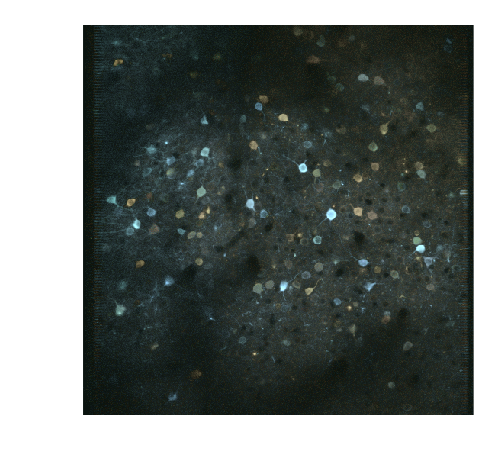

In [51]:
c = Colorize(cmap=pal, scale=1, vmin=0, vmax=25)
img = c.transform(tune,background=mean.clip(min=0, max=300),mask=np.sqrt(rsq).clip(min=0.05,max=0.6),mixing=.3)
image(img[:,:,iplane])
if savefig:
    plt.savefig(os.path.join(path,'figuresImaging','Overlay%s%s.eps' % (a,str(iplane))))

#### Plot sources

Load sources and plot overlay on mean map

In [52]:
sources = tsc.loadSources(os.path.join(path,'data',session,'sources','sources.json'))

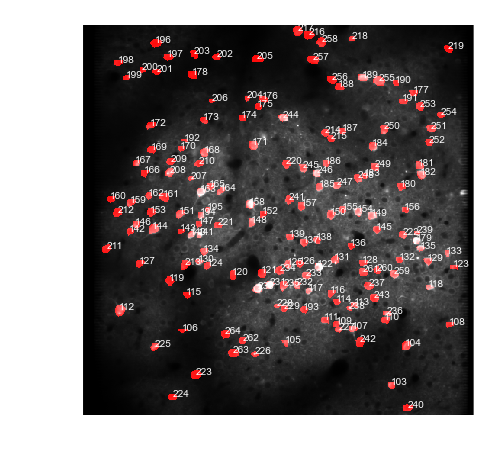

In [53]:
index = np.where([x[2] == iplane for x in sources.centers])[0]
sourcesPlane = SourceModel([np.asarray(sources[s].coordinates)[:,0:2].tolist() for s in index])
img = sourcesPlane.masks(mean.shape[0:2], color='red', base=mean[:,:,iplane].clip(0,500))
image(img)
for s in range(sourcesPlane.count):
    plt.annotate(s=str(index[s]), xy=sourcesPlane[s].center[[1,0]], color='w');

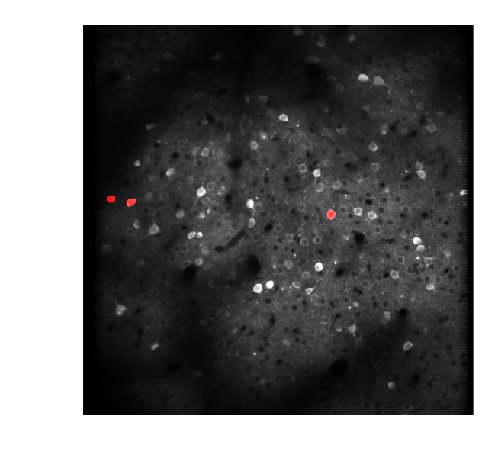

In [54]:
index = [160, 150, 159]
sourcesPlane = SourceModel([np.asarray(sources[s].coordinates)[:,0:2].tolist() for s in index])
img = sourcesPlane.masks(mean.shape[0:2], color='red', outline=False, base=mean[:,:,iplane].clip(0,500))
image(img)
if savefig:
    plt.savefig(os.path.join(path,'figuresImaging','Sources%s%s.eps' % (a,str(iplane))))

#### Plot timeseries

Load covariates

In [55]:
covariates = pd.DataFrame.from_csv(os.path.join(path,'data',session,'params','covariates.csv'))

Load timeseries

In [56]:
timeseries = pd.DataFrame.from_csv(os.path.join(path,'data',session,'sources','timeseries.csv'))

In [57]:
def plotTimeseries(x, start, stop, c, ylabel=None):
    plt.plot((covariates.index[start:stop] - covariates.index[start])/info.loc[a]['rate-hz'], x[start:stop], c=c);
    plt.xlabel('Time (s)')
    if ylabel:
        plt.ylabel(ylabel)

In [58]:
start = 2664
stop = 3104

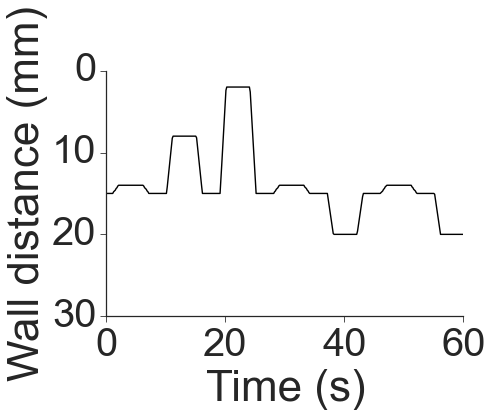

In [71]:
plotTimeseries(covariates.corPos, start, stop, c='k', ylabel='Wall distance (mm)')
plt.xlim([0, 60])
plt.ylim([0, 30])
plt.xticks(range(0,80,20))
plt.yticks(range(0,40,10))
plt.gca().invert_yaxis()
sns.despine()
if savefig:
    plt.savefig(os.path.join(path,'figuresImaging','CorPos%s.eps' % a))

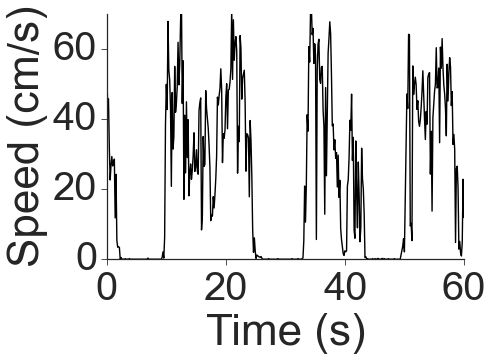

In [73]:
plotTimeseries(covariates.speed, start, stop, c='k', ylabel='Speed (cm/s)')
plt.xlim([0, 60])
plt.ylim([0, 70])
plt.yticks(range(0,80,20))
plt.xticks(range(0,80,20))
sns.despine()

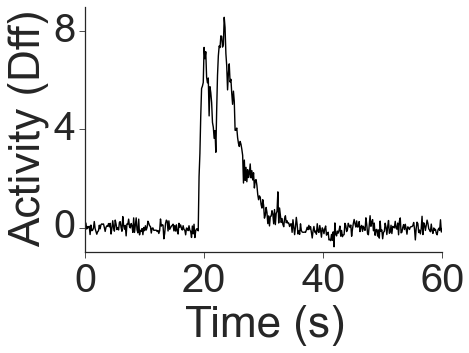

In [83]:
s = 150
plotTimeseries(timeseries.loc[s], start, stop, c='k', ylabel='Activity (Dff)')
plt.xlim([0, 60])
plt.xticks(range(0,80,20))
plt.yticks(range(0,10,4))
plt.ylim([-1, 9])
sns.despine()
if savefig:
    plt.savefig(os.path.join(path,'figuresImaging','Timeseries%s%s.eps' % (a,str(s))))

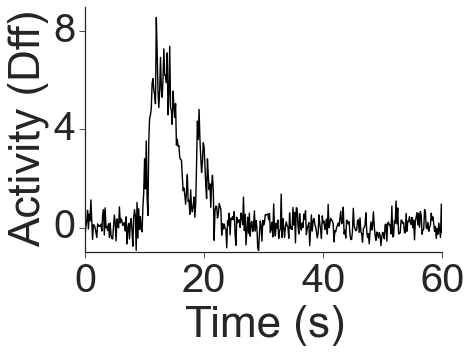

In [81]:
s = 160
plotTimeseries(timeseries.loc[s], start, stop, c='k', ylabel='Activity (Dff)')
plt.xlim([0, 60])
plt.ylim([-1, 9])
plt.xticks(range(0,80,20))
plt.yticks(range(0,10,4))
sns.despine()
if savefig:
    plt.savefig(os.path.join(path,'figuresImaging','Timeseries%s%s.eps' % (a,str(s))))

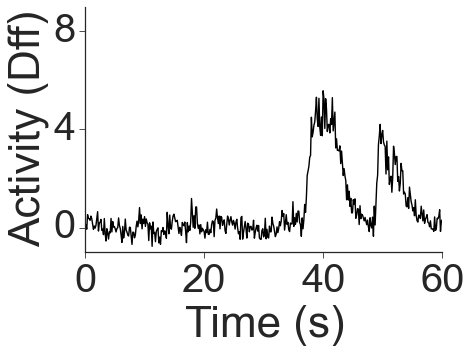

In [82]:
s = 159
plotTimeseries(timeseries.loc[s], start, stop, c='k', ylabel='Activity (Dff)')
plt.xlim([0, 60])
plt.xticks(range(0,80,20))
plt.yticks(range(0,10,4))
plt.ylim([-1, 9])
sns.despine()
if savefig:
    plt.savefig(os.path.join(path,'figuresImaging','Timeseries%s%s.eps' % (a,str(s))))